# Getting the data

## Download the MNIST dataset

In [2]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

The `data` key contains the features of the imagw, which is a 28 x 28 (784px) bitmap of 0 and 1. The `target` key contains the labels -- the digit that represent the image

In [11]:
x,y = mnist["data"], mnist["target"]
print("x shape =", x.shape, "y shape =", y.shape)

x shape = (70000, 784) y shape = (70000,)


User `imshow` to convert a array of pixels to an actual image

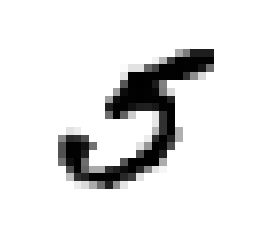

In [15]:
import matplotlib
import matplotlib.pyplot as plt

some_digit = x[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

The image above looks like a "5" and indeed it is a 5:

In [14]:
y[36000]

5.0

## Always create a test and trainset

In [ ]:
x_train, x_test = x[:60000], x[60000:], y[:60000], y[60000:]